# Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import os

In [21]:
df_i_fe = pd.read_pickle('data/df_i_fe.pkl')
df_c_train_fe = pd.read_pickle('data/df_c_train_fe.pkl')
df_t_train_fe = pd.read_pickle('data/df_t_train_fe.pkl')
df_c_val_fe = pd.read_pickle('data/df_c_val_fe.pkl')
df_t_val_fe = pd.read_pickle('data/df_t_val_fe.pkl')
df_c_test_fe = pd.read_pickle('data/df_c_test_fe.pkl')
df_t_test_fe = pd.read_pickle('data/df_t_test_fe.pkl')
df_customers = pd.read_csv('data/customers.csv')


In [20]:
# # Display the head of each DataFrame
# print("Head of df_i_fe:")
# df_i_fe.head()

# print("Head of df_c_train_fe:")
# df_c_train_fe.head()

# print("Head of df_c_val_fe:")
# df_c_val_fe.head()

# print("Head of df_c_test_fe:")
# df_c_test_fe.head()

# print("Head of df_t_train_fe:")
# df_t_train_fe.head()

# print("Head of df_t_val_fe:")
# df_t_val_fe.head()

# print("Head of df_t_test_fe:")
# df_t_test_fe.head()

In [22]:
# Get age as a feature as well
df_customers = df_customers.drop(columns=["FN", "Active", "club_member_status", "fashion_news_frequency", "postal_code"])

# merge df_c_train_fe with df_customers to get age
df_c_train_fe = pd.merge(df_customers, df_c_train_fe, on='customer_id', how='inner')

In [26]:
df_c_train_fe.head(5)

,customer_id,age,total_spent,spending_power,preferred_prod,preferred_color,avg_time_diff_btw_purchase
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,0.111814,medium,Garment Upper body,Black,11 days 12:00:00
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,0.782712,high,Garment Upper body,Black,3 days 10:06:18.947368421
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,0.060983,medium,Underwear,Black,0 days 00:00:00
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,20.0,0.042339,low,Swimwear,Dark Green,0 days 00:00:00
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,56.0,0.772729,high,Garment Upper body,Black,1 days 21:31:02.068965517


In [30]:
print(df_c_train_fe["preferred_prod"].unique())
print()
print(df_c_train_fe["avg_time_diff_btw_purchase"].unique())

['Garment Upper body' 'Underwear' 'Swimwear' 'Garment Full body'
 'Garment Lower body' 'Shoes' 'Socks & Tights' 'Accessories' 'Nightwear'
 'Unknown' 'Bags' 'Items' 'Cosmetic' 'Underwear/nightwear']

<TimedeltaArray>
[         '11 days 12:00:00', '3 days 10:06:18.947368421',
           '0 days 00:00:00', '1 days 21:31:02.068965517',
           '5 days 13:20:00',           '3 days 21:20:00',
           '0 days 08:00:00',           '5 days 08:00:00',
           '1 days 04:26:40',                         NaT,
 ...
           '0 days 21:40:00', '0 days 06:31:06.666666666',
 '1 days 03:08:51.147540983', '1 days 09:30:33.962264150',
           '0 days 17:52:00', '0 days 13:18:32.727272727',
 '0 days 02:26:26.440677966', '0 days 10:19:32.093023255',
 '0 days 05:52:39.183673469', '0 days 03:35:25.984251968']
Length: 3273, dtype: timedelta64[ns]


### Number of clusters 

Text(0, 0.5, 'WCSS')

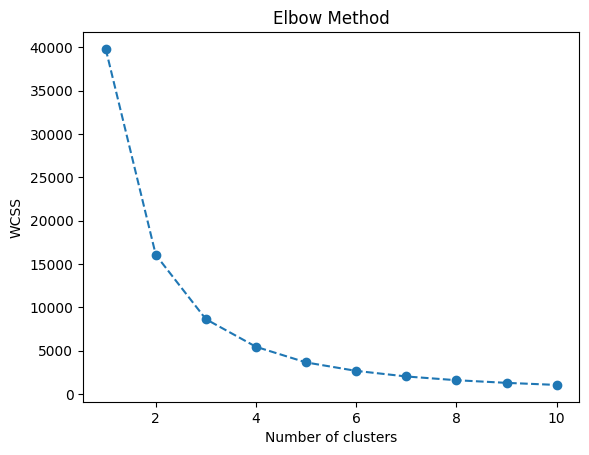

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the number of clusters we should use via the Elbow Method, by checking the Within-Cluster Sum of Square (WCSS)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_c_train_reduced[['total_spent']])
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

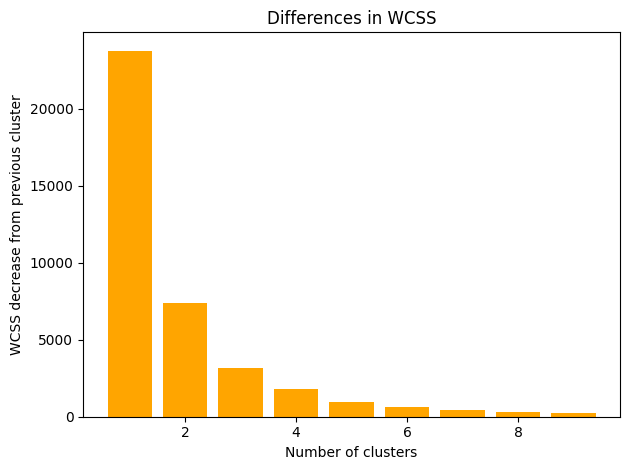

In [47]:
# Compute the differences in consecutive WCSS values to choose number of clusters
wcss_diff = [wcss[i - 1] - wcss[i] for i in range(1, len(wcss))]
plt.bar(range(1, 10), wcss_diff, color='orange')
plt.title('Differences in WCSS')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS decrease from previous cluster')


plt.tight_layout()
plt.show()

#### Upon visual inspection of the Elbow Method graph, it is evident that the elbow point is approximately around ***3 clusters***. Additionally, analyzing the difference in consecutive WCSS values provides further insight into the optimal number of clusters. Notably, the most substantial drop in WCSS occurs when transitioning from 2 to 3 clusters, suggesting that the addition of a third cluster significantly improves the clustering quality. 

#### However, beyond three clusters, the decrease in WCSS becomes less pronounced, indicating diminishing returns in terms of clustering improvement. Moreover, increasing the number of clusters excessively may lead to overfitting, where the model captures noise in the data rather than meaningful patterns, potentially reducing the generalization ability of the clustering model. Therefore, based on both visual inspection and the analysis of WCSS differences, selecting three clusters appears to be a reasonable choice for this dataset.

### Categorising Spending Power

In [48]:
quantiles_train = df_c_train_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_val = df_c_val_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_test = df_c_test_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])

def categorize_spending_power(amount, quantiles):
    if amount <= quantiles[0.25]:
        return 'low'
    elif amount <= quantiles[0.75]:
        return 'medium'
    else:
        return 'high'

df_c_train_reduced['spending_power'] = df_c_train_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_train))
df_c_val_reduced['spending_power'] = df_c_val_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_val))
df_c_test_reduced['spending_power'] = df_c_test_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_test))

In [53]:
print(df_c_test_reduced['spending_power'].value_counts())
print(df_c_val_reduced['spending_power'].value_counts())
print(df_c_train_reduced['spending_power'].value_counts())
print(df_c_train_reduced)

spending_power
medium    148271
low        74241
high       74171
Name: count, dtype: int64
spending_power
medium    108324
low        54783
high       54369
Name: count, dtype: int64
spending_power
medium    234880
low       117452
high      117441
Name: count, dtype: int64
                                              customer_id  total_spent  \
0       00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...     0.111814   
1       0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...     0.782712   
2       00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...     0.060983   
3       0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...     0.042339   
4       00009d946eec3ea54add5ba56d5210ea898def4b46c685...     0.772729   
...                                                   ...          ...   
469768  ffff1c80bd2dede87deda612527c3df06d2fb270b85602...     0.064356   
469769  ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...     0.101610   
469770  ffff61677073258d461e043cc9ed4ed97be5617a920640... 

### Insights into product types purchased by different spending power groups

In [73]:
# Tagging products purchased to customers
df_train_merged = pd.merge(df_t_train, df_i[['article_id', 'product_type_name']], on='article_id', how='left')
df_val_merged = pd.merge(df_t_val, df_i[['article_id', 'product_type_name']], on='article_id', how='left')
df_test_merged = pd.merge(df_t_test, df_i[['article_id', 'product_type_name']], on='article_id', how='left')

df_train_merged_with_spending_power = pd.merge(df_train_merged, df_c_train_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')
df_val_merged_with_spending_power = pd.merge(df_val_merged, df_c_val_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')
df_test_merged_with_spending_power = pd.merge(df_test_merged, df_c_test_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')

print("Train Data:")
print(df_train_merged_with_spending_power.head())

print("\nValidation Data:")
print(df_val_merged_with_spending_power.head())

print("\nTest Data:")
print(df_test_merged_with_spending_power.head())


Train Data:
       t_dat                                        customer_id  article_id  \
0 2019-04-01  000747860042b94e85707605c2a627c6ba30c4117d025d...   732725002   
1 2019-04-01  001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...   697060014   
2 2019-04-01  001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...   758200004   
3 2019-04-01  0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...   769965001   
4 2019-04-01  0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...   709269004   

      price  sales_channel_id product_type_name spending_power  
0  0.050831                 1             Dress           high  
1  0.025407                 2            Blouse           high  
2  0.067780                 2            Blouse           high  
3  0.042356                 2             Dress           high  
4  0.042356                 2             Dress           high  

Validation Data:
       t_dat                                        customer_id  article_id  \
0 2019-06-15  00015c1a121e

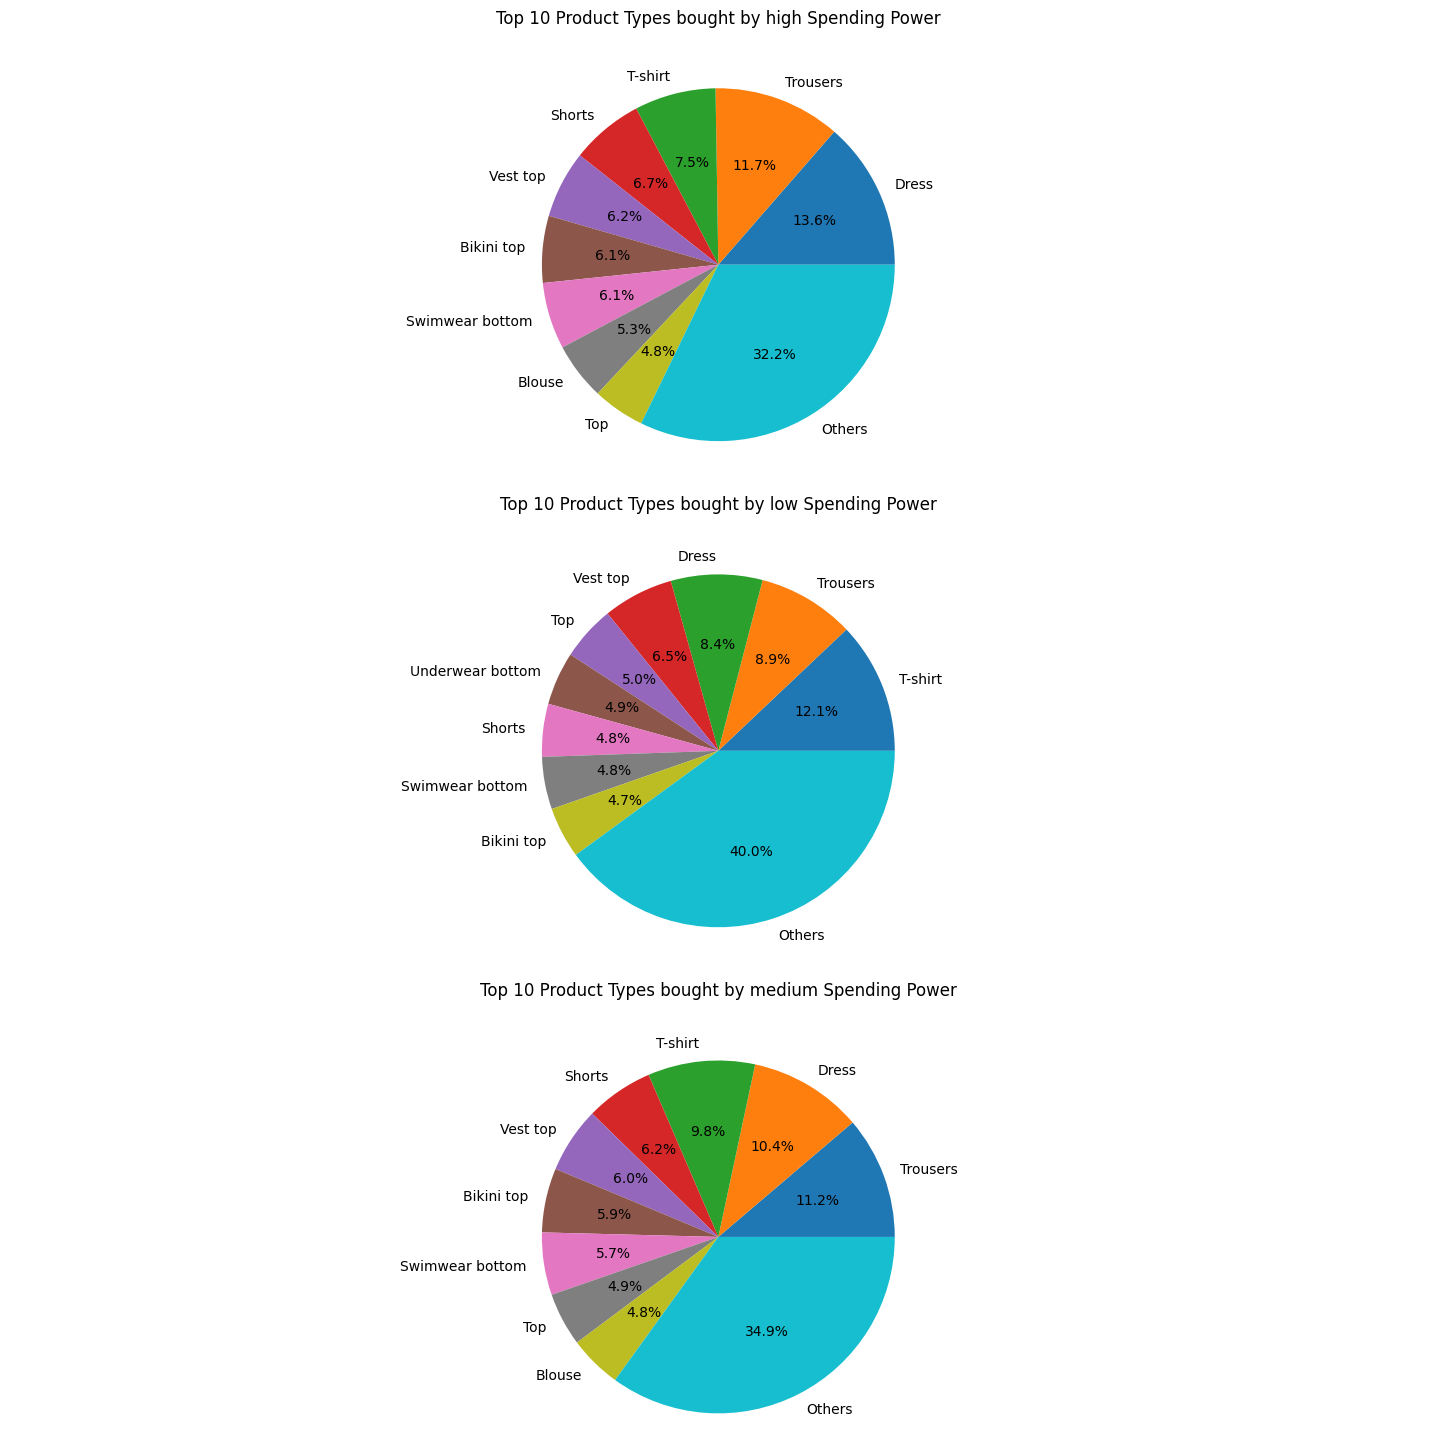

In [72]:
import matplotlib.pyplot as plt

# Group data by spending power and product type and count occurrences
grouped_data = df_train_merged_with_spending_power.groupby(['spending_power', 'product_type_name']).size().reset_index(name='count')
spending_power_categories = grouped_data['spending_power'].unique()

# Plot pie chart for each spending power category
plt.figure(figsize=(15, 5*len(spending_power_categories)))
for i, spending_power in enumerate(spending_power_categories):
    
    # Filter data for the current spending power category
    subset_data = grouped_data[grouped_data['spending_power'] == spending_power]
    
    # Select top 10 product types
    top_10_product_types = subset_data.nlargest(10, 'count')
    
    # Calculate the sum of counts for top 9 product types
    top_9_count = top_10_product_types.iloc[:9]['count'].sum()
    
    # Calculate the count for "Others"
    others_count = subset_data['count'].sum() - top_9_count
    
    # Create a list of labels for the pie chart
    pie_labels = top_10_product_types.iloc[:9]['product_type_name'].tolist()
    pie_labels.append('Others')
    
    # Create a list of counts for the pie chart
    pie_counts = top_10_product_types.iloc[:9]['count'].tolist()
    pie_counts.append(others_count)
    
    # Plot pie chart
    plt.subplot(len(spending_power_categories), 1, i+1)
    plt.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%')
    plt.title(f'Top 10 Product Types bought by {spending_power} Spending Power', y=1.1)
    plt.axis('equal') 

plt.tight_layout(pad=3.0)
plt.show()
